In [1]:
# Combinatorial Average Motif (CAM) splice site scoring model. 
# Each individual, positional subset model conditions on two nucleotides and considers all other positions (long-range dependencies).
# Most importantly, you then average over all two-nucleotide conditioned positional subset models to derive the overall CAM probability value.
# The formula is shown below. CAM can be extended to 30+ nucleotides, but becomes slower due to positional subset growth rate (length choose 2).

# Chris Burge, MIT, came up the model, I implemented and optimized the model.

import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from IPython.display import display, Math


In [8]:
# Below is a succinct description of the model.

# Let S be a random variable representing a sequence of length n we want to measure, and let x be a specific n-mer sequence.
# M is a positional subset model conditioned on two nucleotide positions.
# To calculate the probability of a positional subset model, its the frequency of the conditioned di-nucleotide, 
# then the product of all tri-nucleotide frequencies conditioned on the positional subset di-nucleotides.
# Most importantly, the average of all positional subset models is the CAM model. Let u2 be the set of positional subset models
# |u2| is the cardinality/size of the set.
# Lastly, take the log2 ratio of foreground (splice sites) and background (deep intronic) probabilities.
# Notably, one does not need to take the average of positional subset models. Ideally, one would measure model performance and adjust the weights via optimization.
# I've done it before via cross-entropy loss and gradient descent, but I was not able to improve the model significantly in the short time I tried.

display(Math(r'$$ P(S = x \mid M_{1,3}) = f_{1,3}(x_1, x_3) \prod_{k \neq 1,3} \frac{f_{1,3,k}(x_1, x_3, x_k)}{f_{1,3}(x_1, x_3)}$$'))
display(Math(r'$$P(S = x|\mu2) = \frac{1}{|\mu2|} \sum_{M_{i,j} \epsilon \mu2} P(S=x|M_{i,j})$$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
# Train-test split of intronic sequences.
# Pull the sequences you want to train and test on.

DataBase = '/Users/nrk/Desktop/PhD/Database/SpliceSites/'

# 172k
with open(DataBase + 'train3_true.txt') as f: positive_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 3.4m. A random subset of this will go into the test set, too large.
with open(DataBase + 'train3_null.txt') as f: negative_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 12k
with open(DataBase + 'test3_true.txt') as f: positive_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 240k
with open(DataBase + 'test3_null.txt') as f: negative_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])

In [4]:
# CAM training.
# Create training sequence dataset array first, then create CAM arrays.

start = time.time()

def camv2_train(positive, negative, length):

    training = [positive, negative]
    
    # Array shape = (Positive/Negative, samples, positions, 4 nt) 
    seq_array = np.zeros((2, len(training[0]+training[1]), length, 4), dtype = np.float64)
    
    # Subset of splice sites vs deep intronic sequence
    for ind0, subset in enumerate(training):
        # Sequences within that subset
        for ind1, seq in tqdm(enumerate(subset)):
            if len(seq) == length:
                # One-hot encoded base per position for each sample
                for ind2, nt in enumerate(seq):
                    if nt == 'A':
                        seq_array[ind0, ind1, ind2] += [1,0,0,0]
                    elif nt == 'C':
                        seq_array[ind0, ind1, ind2] += [0,1,0,0]
                    elif nt == 'G':
                        seq_array[ind0, ind1, ind2] += [0,0,1,0]
                    elif nt == 'T':
                        seq_array[ind0, ind1, ind2] += [0,0,0,1]

    # Tri_array = conditional p(tri-nt|di_nt), di_array = p(di-nt). 
    tri_array = np.zeros((2, length, length, length, 4, 4, 4), dtype = np.float64)
    di_array = np.zeros((2, length, length, 4, 4), dtype = np.float64)
    
    # Splice site vs deep intronic subset.
    for subset, seq in enumerate(training):
        # Position 1 in sequence.
        for pos1 in tqdm(range(length)):
            # Position 2 in sequence with no overlap with position 1.
            for pos2 in range(length): #used to have pos1 +1
                # 16 di-nt
                for base1 in range(4):
                    for base2 in range(4):
                        if pos1 != pos2:
                            # Given two positions and two observed nt, find the indices/samples that have that di-nt combination
                            di_indices = np.where((seq_array[subset, :, pos1, base1] == 1) & (seq_array[subset, :, pos2, base2] == 1))[0] 
                            # Frequency of di-nt at those positions, adjusted with +1 for di-nt and +16 for total. 
                            di_array[subset, pos1, pos2, base1, base2] = (len(di_indices) + 1) / (len(seq) + 16)

                            # All posible third positions conditioned on the first two nt.
                            for pos3 in range(0, length):
                                if pos3 != pos1 and pos3 != pos2:

                                # Pseudocounts +1 to all 4 third nt, therefore +4 to corresponding di-nt.

                                    tri_array[subset, pos1, pos2, pos3, base1, base2] = (seq_array[subset, di_indices, pos3].sum(0) + 1) / (len(di_indices)+4)

    return seq_array, di_array, tri_array

                                                                             
# Should filter sequences by length before entering training to ensure zeros are created optimally.

uni_array, di_array, tri_array = camv2_train([i[-23:] for i in random.sample(positive_train, 10000)], [i[-23:] for i in random.sample(negative_train, 10000)], 23)

end = time.time()
end-start

10000it [00:00, 21902.06it/s]
10000it [00:00, 20230.84it/s]
100%|███████████████████████████████████████████| 23/23 [00:02<00:00,  7.82it/s]


6.9019670486450195

In [5]:
# Once the model is trained, this is how to score a sequence.

def camv2(tests, length):
    
    master = []

    def convert_nt(nt):
        if nt == 'A':
            base = 0
        elif nt == 'C':
            base = 1
        elif nt == 'G':
            base = 2
        elif nt == 'T':
            base = 3
        return base
                
    for test in tqdm(tests):
        
        foreground = []
        background= []
        
        for pos1 in range(0, length):

            for pos2 in range(pos1 + 1, length):
                
                base1 = convert_nt(test[pos1])
                base2 = convert_nt(test[pos2])
                
                # Summing all p(tri-nt) at any given two positions = p(di-nt) at those positions
                # 4 possible tri-nt, when summed together you have the complete p(di-nt)
                
                # Index 0 = splice sites, index 1 = deep intronic
                di = di_array[0, pos1, pos2, base1, base2] # Use sum() if single array contains tri/total instead of tri/di events
                ran_di = di_array[1, pos1, pos2, base1, base2] #sum() look above
                
                # All third positioin possibilities conditioned on two positions.
                # Tri-array can contain p(tri-nt)/p(di-nt) or p(tri-nt). If latter, must divide by p(di-nt).
                # CURRENT: Tri-array = p(tri-nt)/p(di-nt), hence the separate di_array.
                
                for pos3 in range(0, length):
                    
                    if pos3 != pos1 and pos3 != pos2:
                        
                        base3 = convert_nt(test[pos3])
                        tri = tri_array[0, pos1, pos2, pos3, base1, base2, base3]
                        di *= tri #/di look above
                        ran_tri = tri_array[1, pos1, pos2, pos3, base1, base2, base3]
                        ran_di *= ran_tri #/ran_di look above
                        
                # After every 2 fixed positions, save the p(seq|fix di-nt).
                foreground.append(di)
                background.append(ran_di)
                
                
        # All n choose 2 p(seq|fix di-nt), with MaxEnt scores and sequence.
        
        master.append(np.log2(np.mean(foreground)/np.mean(background)))


    return master, foreground, background


In [6]:

one = [i.upper()[-23:] for i in positive_test[:1000]]
two = [i.upper()[-23:] for i in negative_test[:1000]]

true, fore1, back1 = camv2(one, 23)
false, fore2, back2 = camv2(two, 23)


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 371.96it/s]


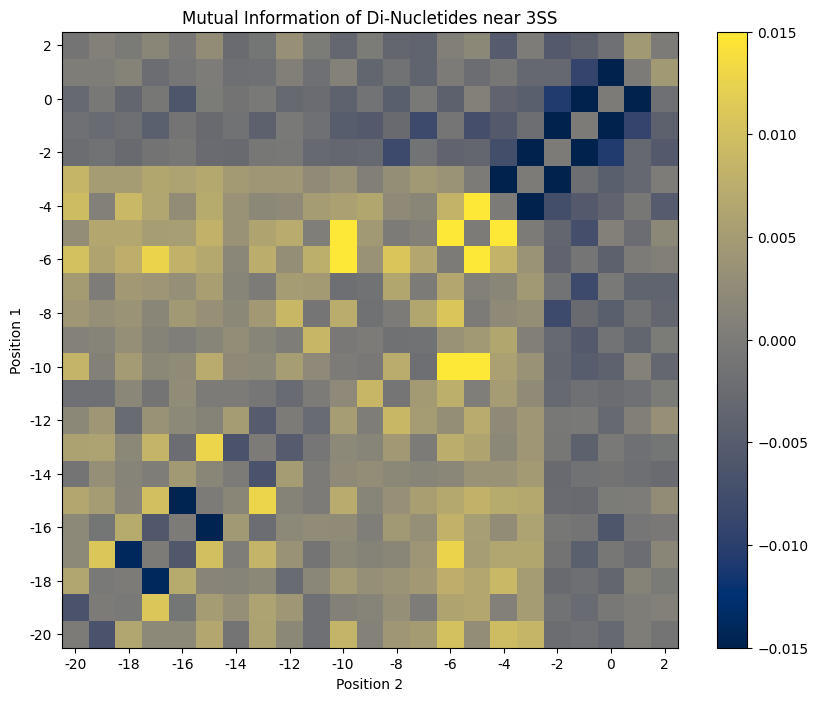

In [7]:
# This is an analysis of the mutual information content between any two positions.
# Can substract background mutual information to see where foreground enhances or depletes information 
# Can also do KL-divergence between foreground and background sets to see how different di-nucleotide distributions are, I did not include this.

singles = np.sum(uni_array[:,:,:], axis = 1) / 10000

length = 23
foreground = np.zeros((length,length))
background = np.zeros((length,length))

for pos1 in range(length):
    for pos2 in range(length):
        
        if pos1 != pos2:
            
            temp = di_array[0, pos1, pos2].ravel() * np.log2(di_array[0, pos1, pos2].ravel() / np.outer(singles[0, pos1], singles[0, pos2]).ravel())
            temp2 = di_array[1, pos1, pos2].ravel() * np.log2(di_array[1, pos1, pos2].ravel() / np.outer(singles[1, pos1], singles[1, pos2]).ravel())

            foreground[pos1,pos2] = temp.sum()
            background[pos1,pos2] = temp2.sum()
                
plt.figure(figsize=(10, 8))
plt.imshow((foreground-background), cmap = 'cividis', origin = 'lower')
plt.clim(-0.015,0.015)
plt.colorbar()
plt.yticks(np.arange(0,length,2), np.arange(-length+3,3,2))
plt.xticks(np.arange(0,length,2), np.arange(-length+3,3,2))
plt.xlabel('Position 2')
plt.ylabel('Position 1')
plt.title('Mutual Information of Di-Nucletides near 3SS')
plt.show()